In [19]:
import numpy as np
import matplotlib.pyplot as plt
from qubit_zz_coupling.core import setup_operators, solve_t1, solve_t2, make_population, plot_t1, plot_t2
from qutip import basis, tensor
from qtt.algorithms.functions import gauss_ramsey, fit_gauss_ramsey, plot_gauss_ramsey_fit


In [39]:
# Define system parameters
SYSTEM_PARAMS = {
    "fq1": 3.2,  # GHz, Qubit 1 frequency
    "fq2": 3.35,  # GHz, Qubit 2 frequency
    "fTLS": 3.2,  # GHz, TLS frequency (resonant with Qubit 1)
    "JTLS": 0.0135,  # Coupling strength between Qubit 1 and TLS
    "relaxation": {"q1": 1/20, "q2": 1/25, "TLS": 1/5},  # Relaxation rates
    "dephasing": {"q1": 1/15, "q2": 1/18, "TLS": 1/3},  # Dephasing rates
    "Jzz": 0.0185, # Jzz coupling
    "Jxx": 0.01, # Jxx coupling
    "time_points": np.linspace(0, 100, 200)  # Time points in μs
}

H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

# get times
tlist = SYSTEM_PARAMS["time_points"]

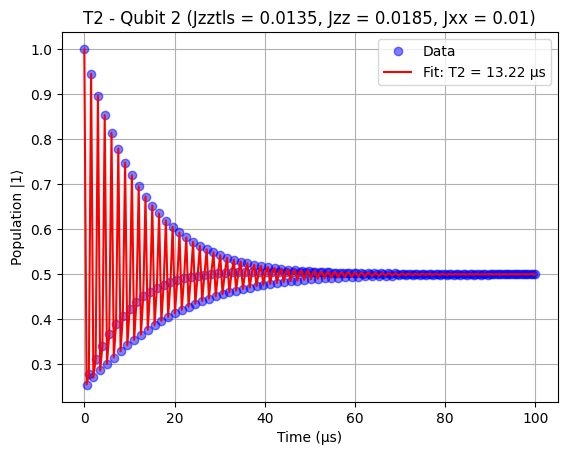

In [40]:
# T2 measurement for Qubit 1 
psi0 = tensor(basis(2, 1), (basis(2, 0) + basis(2, 1)).unit(),  basis(2, 1))  # |+⟩|1⟩|1⟩


first_guess = [0.5, 1.0 / SYSTEM_PARAMS["dephasing"]["q2"], # best guess
                  SYSTEM_PARAMS["fq2"], 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False)
plot_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, "Qubit 2", SYSTEM_PARAMS)
plt.show()

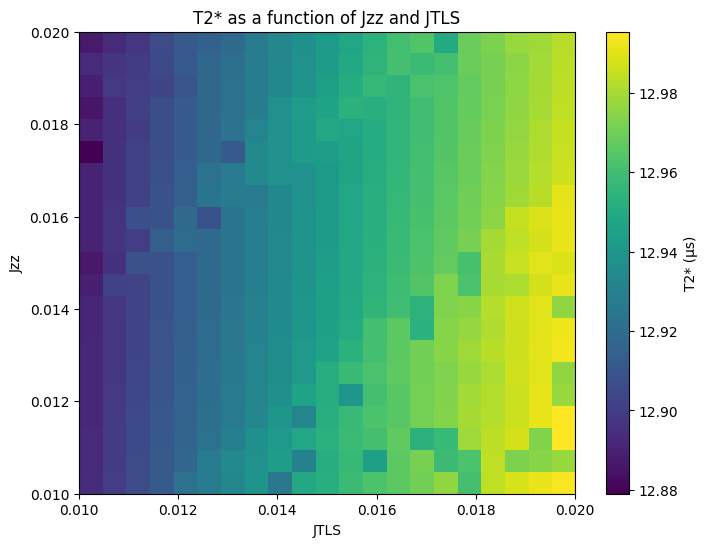

[[12.89382749 12.90007084 12.90621606 12.91215433 12.92228788 12.92761541
  12.93257332 12.9392668  12.92583187 12.94915703 12.95256556 12.95852317
  12.96306764 12.96610423 12.97058051 12.97608449 12.96101235 12.98424955
  12.98818543 12.99206636 12.99407892]
 [12.8933781  12.89954014 12.90558941 12.91159984 12.91742139 12.9274681
  12.93403287 12.93805451 12.94407415 12.93016408 12.95155822 12.95696678
  12.94529866 12.96601146 12.97164033 12.95865178 12.9626541  12.98404888
  12.97233167 12.97454085 12.97751731]
 [12.89294529 12.89906089 12.90506271 12.91096274 12.91677207 12.92250066
  12.92947409 12.93739008 12.94210703 12.94878313 12.9535272  12.95814156
  12.9611713  12.96706461 12.95374756 12.95745222 12.97841989 12.98382832
  12.98777556 12.97339658 12.99541025]
 [12.89257106 12.89861495 12.90457804 12.91043016 12.91620092 12.92184321
  12.92742513 12.93288542 12.94005783 12.93180111 12.95186064 12.95790738
  12.96243132 12.96538623 12.97116086 12.97365567 12.97956067 12.98232

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from qubit_zz_coupling.core import setup_operators, solve_t2
from qutip import basis, tensor

# Define parameter ranges
Jzz_vals = np.linspace(0.01, 0.02, 21)
JTLS_vals = np.linspace(0.01, 0.02, 21)
T2_matrix = np.zeros((len(Jzz_vals), len(JTLS_vals)))

# Base system parameters (without Jzz and JTLS)
base_params = {
    "fq1": 3.2,
    "fq2": 3.3,
    "fTLS": 3.2,
    "relaxation": {"q1": 1/20, "q2": 1/25, "TLS": 1/5},
    "dephasing": {"q1": 1/15, "q2": 1/18, "TLS": 1/3},
    "Jxx": 0.03,
    "time_points": np.linspace(0, 100, 200)
}

tlist = base_params["time_points"]

for i, Jzz in enumerate(Jzz_vals):
    for j, JTLS in enumerate(JTLS_vals):
        # Update parameters for this scan
        params = base_params.copy()
        params["Jzz"] = Jzz
        params["JTLS"] = JTLS

        # Setup system
        H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
        psi0 = tensor( basis(2, 1), (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1))  # |+⟩|1⟩|1⟩
        first_guess = [0.5, 1.0 / params["dephasing"]["q2"], params["fq2"], 0.0, 0.5]

        # Solve T2 and store the fitted T2 value
        try:
            fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False, use_fit_gauss=True)
        except:
            print(f"Error solving T2 for Jzz={Jzz}, JTLS={JTLS}")
            continue 
        T2_matrix[i, j] = fit_par[1]  # T2* is the second parameter

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(T2_matrix, origin='lower', aspect='auto',
           extent=[JTLS_vals[0], JTLS_vals[-1], Jzz_vals[0], Jzz_vals[-1]],
           cmap='viridis')
plt.colorbar(label='T2* (μs)')
plt.xlabel('JTLS')
plt.ylabel('Jzz')
plt.title('T2* as a function of Jzz and JTLS')
plt.show()

print(T2_matrix)

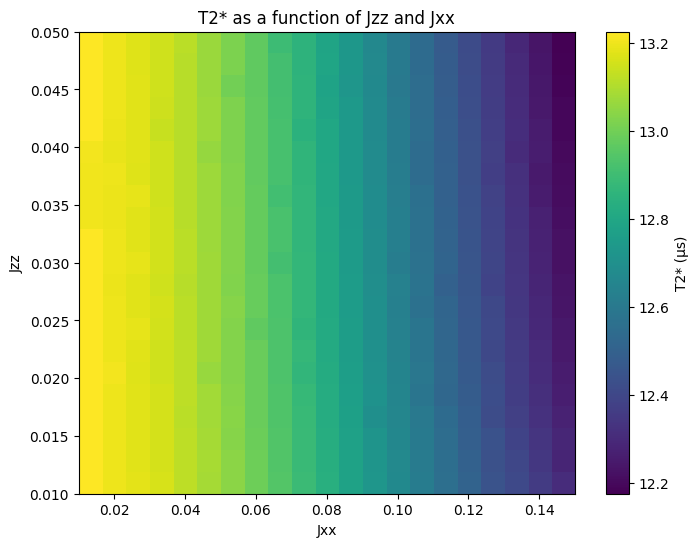

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from qubit_zz_coupling.core import setup_operators, solve_t2
from qutip import basis, tensor

# Define parameter ranges
Jzz_vals = np.linspace(0.01, 0.05, 21)
Jxx_vals = np.linspace(0.01, 0.15, 21)
T2_matrix = np.zeros((len(Jzz_vals), len(Jxx_vals)))

# Base system parameters (without Jzz and Jxx)
base_params = {
    "fq1": 3.2,
    "fq2": 3.35,
    "fTLS": 3.2,
    "relaxation": {"q1": 1/20, "q2": 1/25, "TLS": 1/5},
    "dephasing": {"q1": 1/15, "q2": 1/18, "TLS": 1/3},
    "JTLS": 0.05,
    "time_points": np.linspace(0, 100, 200)
}

tlist = base_params["time_points"]

for i, Jzz in enumerate(Jzz_vals):
    for j, Jxx in enumerate(Jxx_vals):
        # Update parameters for this scan
        params = base_params.copy()
        params["Jzz"] = Jzz
        params["Jxx"] = Jxx

        # Setup system
        H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
        psi0 = tensor(basis(2, 1), (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1))  # |+⟩|1⟩|1⟩
        first_guess = [0.5, 1.0 / params["dephasing"]["q2"], params["fq2"], 0.0, 0.5]

        # Solve T2 and store the fitted T2 value
        try:
            fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False)
        except Exception as e:
            print(f"Error solving T2 for Jzz={Jzz}, Jxx={Jxx}: {e}")
            continue
        T2_matrix[i, j] = fit_par[1]  # T2* is the second parameter

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(T2_matrix, origin='lower', aspect='auto',
           extent=[Jxx_vals[0], Jxx_vals[-1], Jzz_vals[0], Jzz_vals[-1]],
           cmap='viridis')
plt.colorbar(label='T2* (μs)')
plt.xlabel('Jxx')
plt.ylabel('Jzz')
plt.title('T2* as a function of Jzz and Jxx')
plt.show()